In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from wordcloud import WordCloud
import networkx as nx

In [11]:
data = pd.read_csv("RetailPurchase_Data.csv", encoding="utf-8", sep=None, engine='python')
data.columns = ['InvoiceNo', 'ItemDescription', 'Quantity', 'Date', 'Price', 'CustomerID', 'Country']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   InvoiceNo        522064 non-null  object 
 1   ItemDescription  520609 non-null  object 
 2   Quantity         522064 non-null  int64  
 3   Date             522064 non-null  object 
 4   Price            522064 non-null  object 
 5   CustomerID       388023 non-null  float64
 6   Country          522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [4]:
data.head()

,InvoiceNo,ItemDescription,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom


### **Data Cleaning**

In [13]:
#converting 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M', errors='coerce')

In [15]:
#converting 'Price' to numeric format (replace commas with dots)
data['Price'] = data['Price'].astype(str).str.replace(',', '.').astype(float)

In [16]:
#dropping rows with missing values in critical columns, since no imputation technique can be used to create customers
data.dropna(subset=['ItemDescription', 'CustomerID'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 388023 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo        388023 non-null  object        
 1   ItemDescription  388023 non-null  object        
 2   Quantity         388023 non-null  int64         
 3   Date             388023 non-null  datetime64[ns]
 4   Price            388023 non-null  float64       
 5   CustomerID       388023 non-null  float64       
 6   Country          388023 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 23.7+ MB


In [ ]:
#correcting the datatype of bill

### **Exploratory Data Analysis**

<ipython-input-17-866dacc348d2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.index, y=top_items.values, palette='coolwarm')


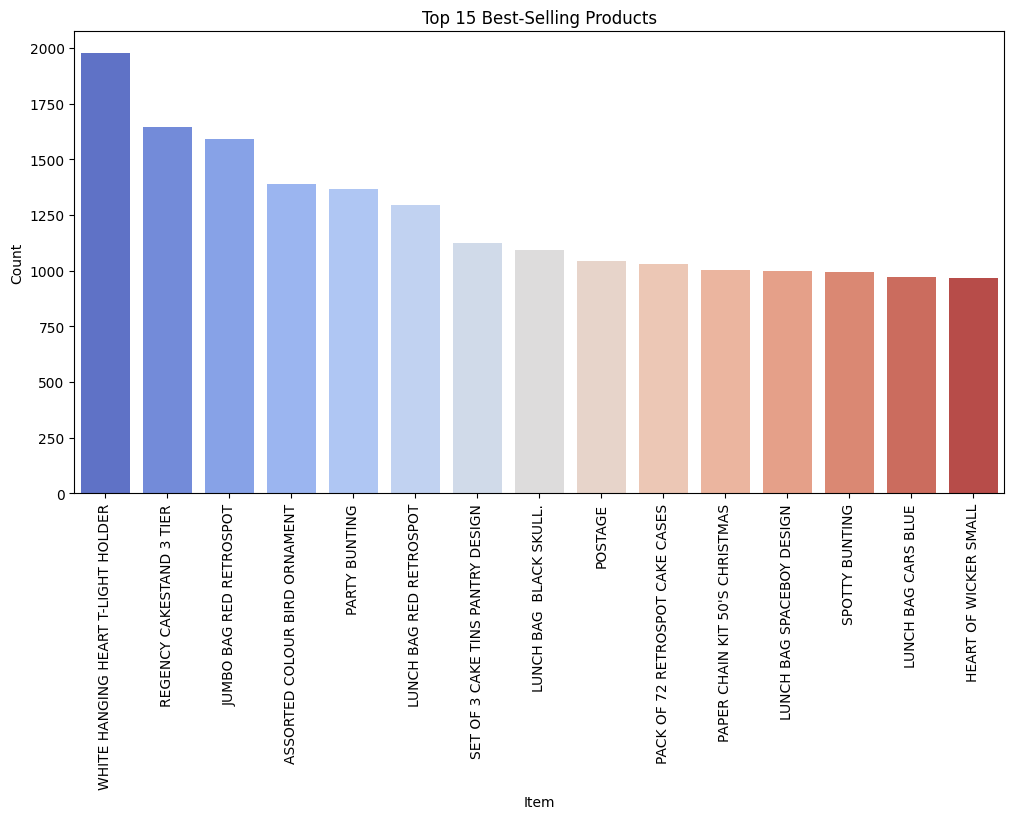

In [17]:
#top-selling products
plt.figure(figsize=(12, 6))
top_items = data['ItemDescription'].value_counts().head(15)
sns.barplot(x=top_items.index, y=top_items.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Top 15 Best-Selling Products')
plt.xlabel('Item')
plt.ylabel('Count')
plt.show()

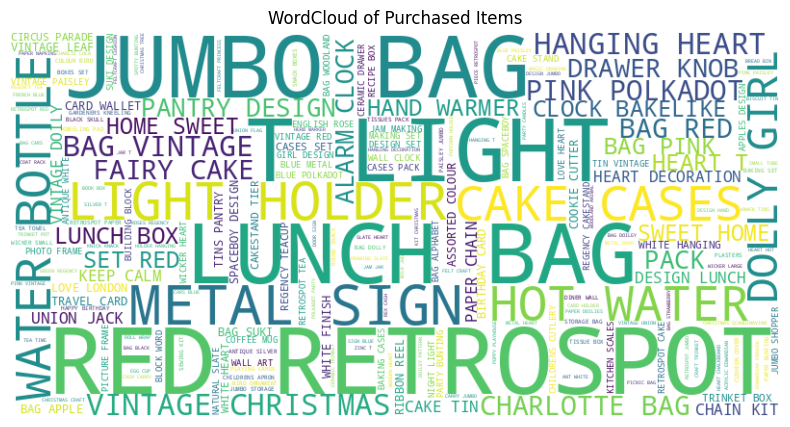

In [18]:
#WordCloud of most frequent products
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['ItemDescription']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Purchased Items")
plt.show()

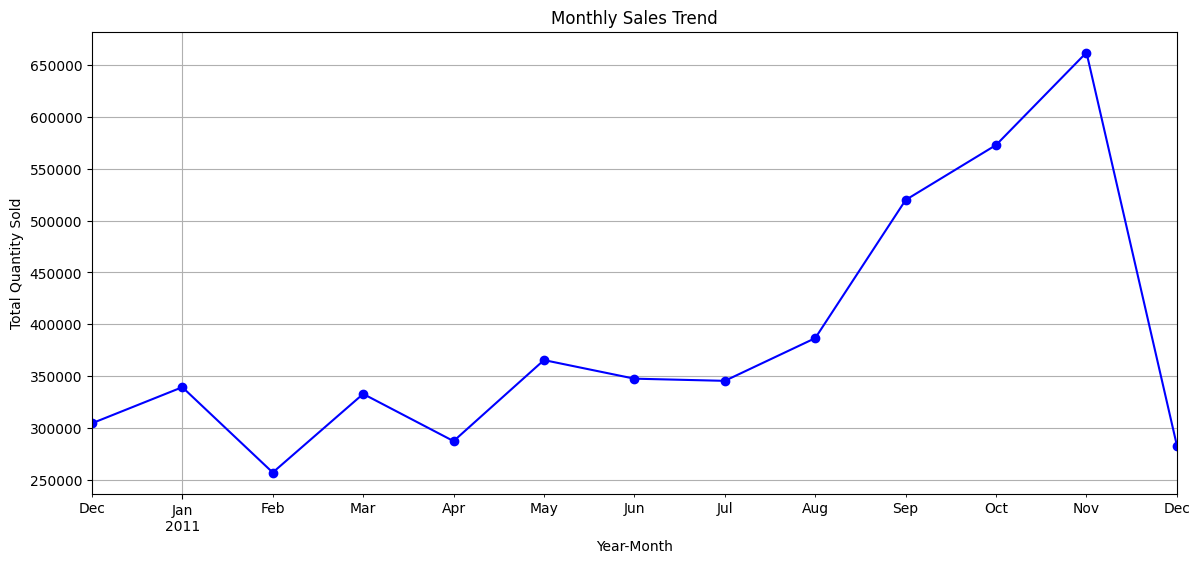

In [19]:
#Time Series Analysis of Sales Trend
data['YearMonth'] = data['Date'].dt.to_period('M')
monthly_sales = data.groupby('YearMonth')['Quantity'].sum()
plt.figure(figsize=(14, 6))
monthly_sales.plot(marker='o', color='b', linestyle='-')
plt.title('Monthly Sales Trend')
plt.xlabel('Year-Month')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.show()

### **Feature Engineering**

In [23]:
#total revenue per transaction
data['TotalRevenue'] = data['Quantity'] * data['Price']

In [24]:
#total quantity per invoice
data['TransactionSize'] = data.groupby('InvoiceNo')['Quantity'].transform('sum')

In [25]:
# Purchase frequency per customer
data['CustomerPurchaseFrequency'] = data.groupby('CustomerID')['InvoiceNo'].transform('nunique')

In [26]:
data.value_counts('Country')

,count
Country,
United Kingdom,354345
Germany,9042
France,8342
Spain,2485
Netherlands,2363
Belgium,2031
Switzerland,1842
Portugal,1462
Australia,1185


In [27]:
#filtering data for United Kingdom since it has the max data
filtered_data = data[data['Country'] == 'United Kingdom']

In [28]:
#creating a basket matrix for Market Basket Analysis
basket = filtered_data.pivot_table(index='InvoiceNo', columns='ItemDescription', values='Quantity', aggfunc='sum', fill_value=0)
basket = (basket > 0).astype(int)

### **Market Basket Analysis - Apriori**

In [29]:
frequent_itemsets = apriori(basket, min_support=0.03, use_colnames=True)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [30]:
#defining Association Rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

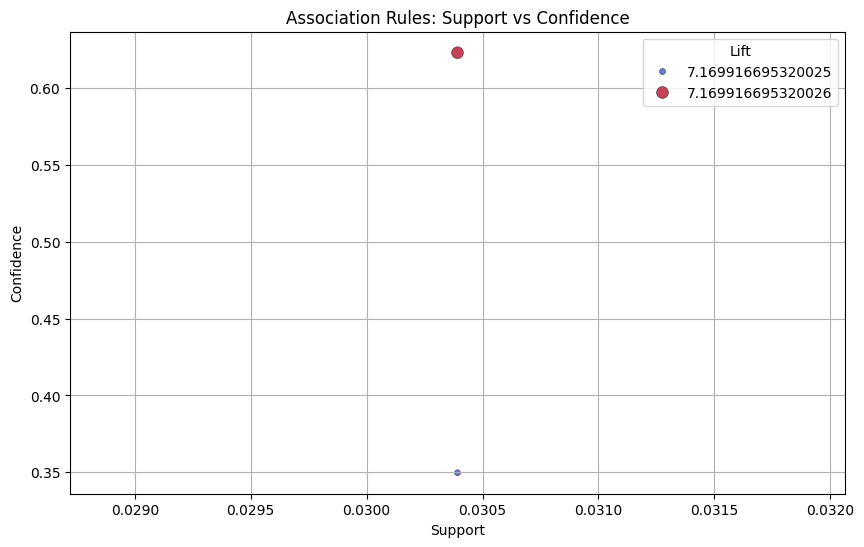

In [31]:
#visualizing Association Rules
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rules['support'], y=rules['confidence'], size=rules['lift'], hue=rules['lift'], palette='coolwarm', edgecolors='black', alpha=0.75)
plt.title('Association Rules: Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(title='Lift', loc='upper right')
plt.grid()
plt.show()

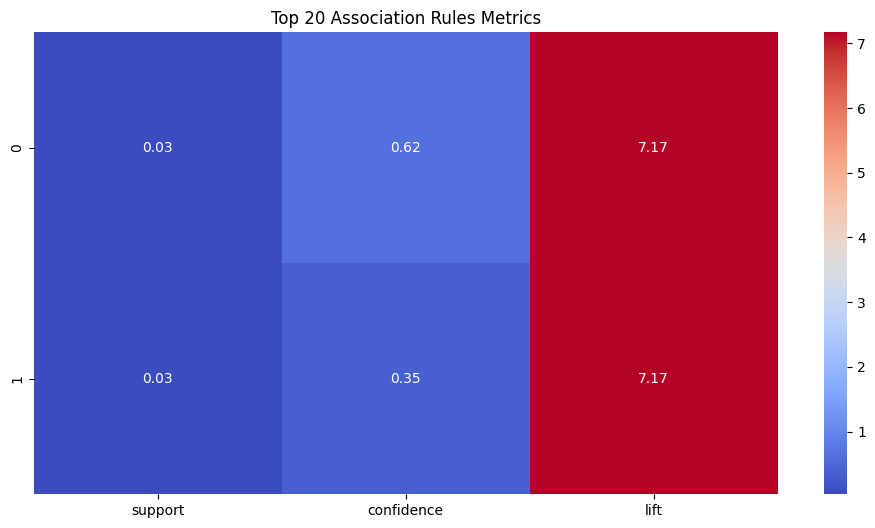

In [32]:
# Heatmap of top rules
plt.figure(figsize=(12, 6))
top_rules = rules.sort_values(by='lift', ascending=False).head(20)
sns.heatmap(top_rules[['support', 'confidence', 'lift']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 20 Association Rules Metrics')
plt.show()

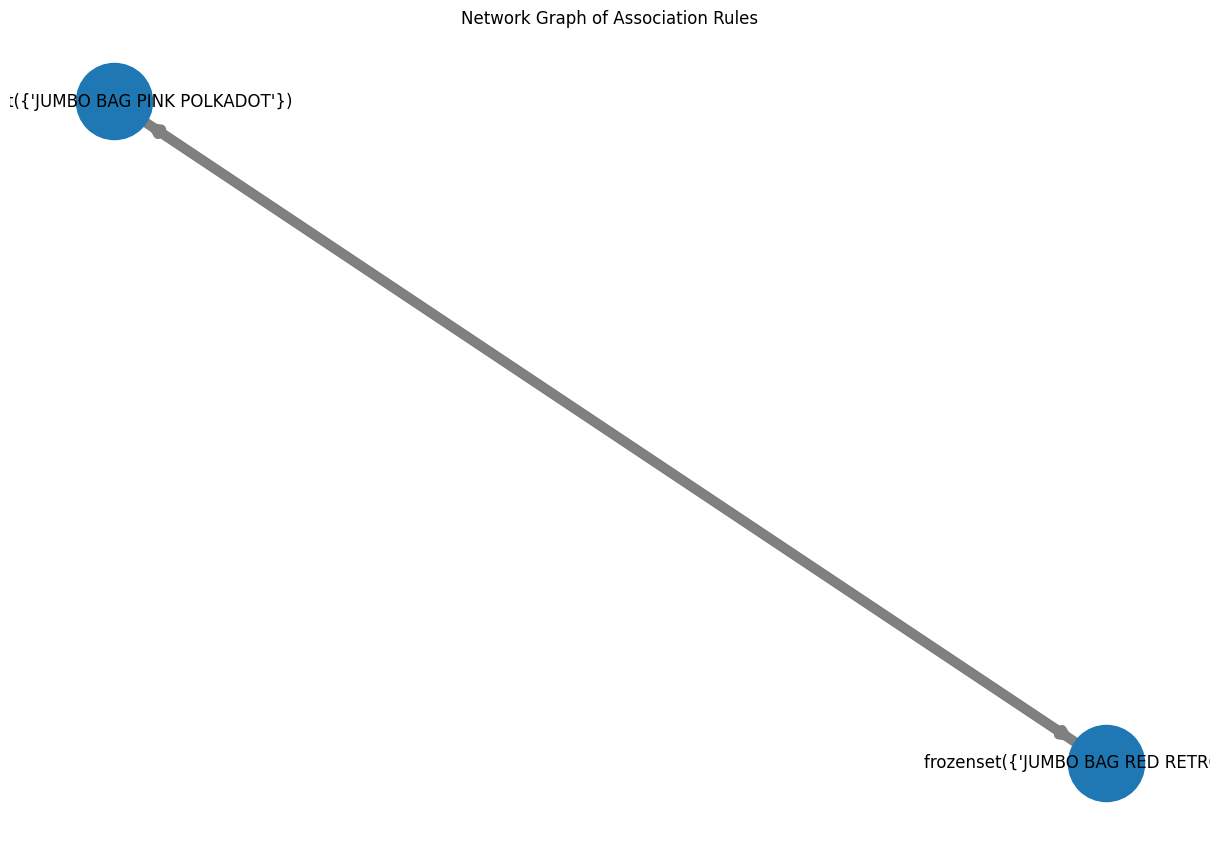

In [33]:
# Network Graph of Strongest Rule
G = nx.DiGraph()
for idx, row in top_rules.iterrows():
    G.add_edge(frozenset(row['antecedents']), frozenset(row['consequents']), weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=3000, edge_color='grey', width=[d['weight'] for (u, v, d) in G.edges(data=True)])
plt.title("Network Graph of Association Rules")
plt.show()

In [34]:
# Create a pivot table for product sales per month
product_sales_pivot = data.pivot_table(index='YearMonth', columns='ItemDescription', values='Quantity', aggfunc='sum', fill_value=0)

print(product_sales_pivot.head())

ItemDescription  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
YearMonth                                                             
2010-12                             523                          48   
2011-01                             276                          60   
2011-02                             216                          79   
2011-03                             336                         220   
2011-04                             216                         152   

ItemDescription  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
YearMonth                                                               
2010-12                                 15                          2   
2011-01                                 69                         11   
2011-02                                  7                         15   
2011-03                                 69                         10   
2011-04                                 54                      

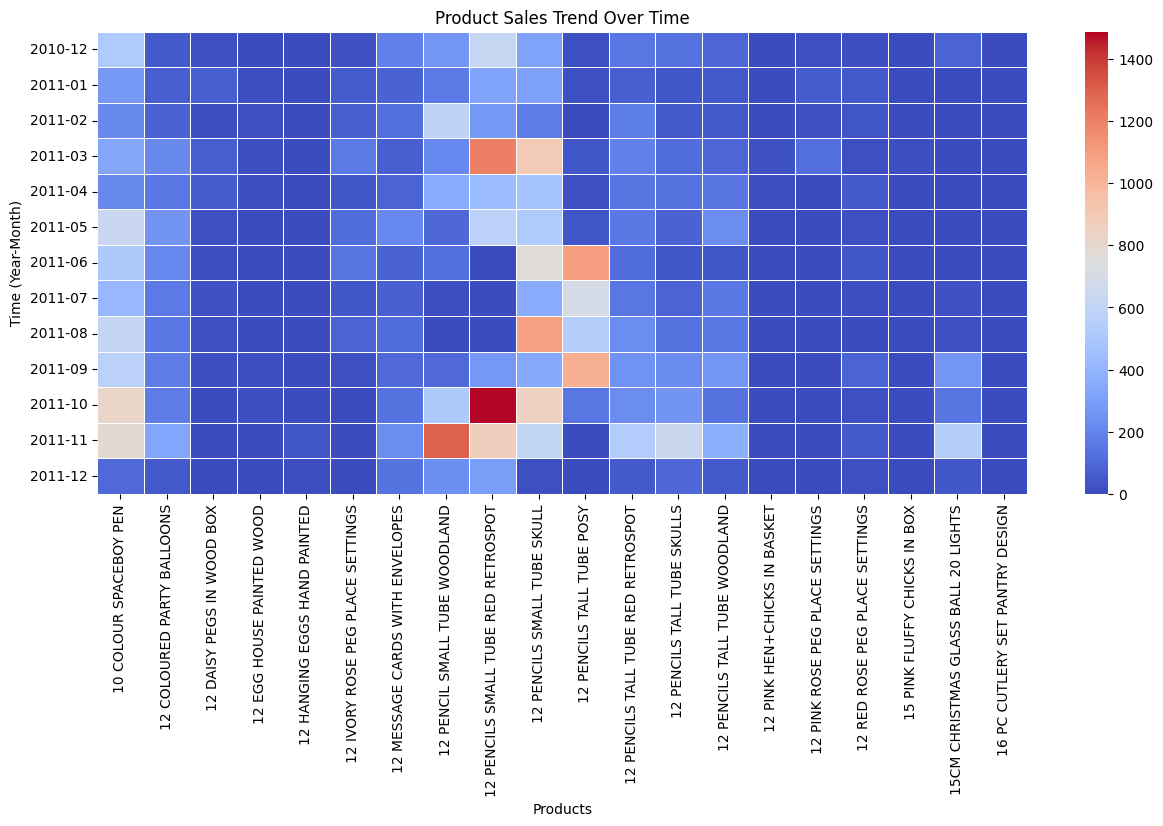

In [35]:
# Plot heatmap of top-selling products over time
plt.figure(figsize=(15, 6))
sns.heatmap(product_sales_pivot.iloc[:, :20], cmap='coolwarm', linewidths=0.5)  # Limiting to first 20 products for clarity
plt.title('Product Sales Trend Over Time')
plt.xlabel('Products')
plt.ylabel('Time (Year-Month)')
plt.xticks(rotation=90)
plt.show()